In [1]:
%matplotlib inline
from __future__ import division
from vis_common import load_frame, STORE
from crawl_data import CANON_SPECIES
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

f = load_frame(include=[])
ilost = STORE['ilost']
iwon = STORE['iwon']
iquit = STORE['iquit']

species = f['species'].cat.categories
drac_species = [sp for sp in species if 'draconian' in sp]
idrac = f['species'].isin(drac_species)
colored_dracs = [sp for sp in drac_species if sp != 'draconian']
cdrac_index = f['species'].isin(colored_dracs)

In my [previous post](/blog/dcss_species) analyzing data from the roguelike Dungeon Crawl Stone Soup, I showed this chart of win rates for different colours of draconians:

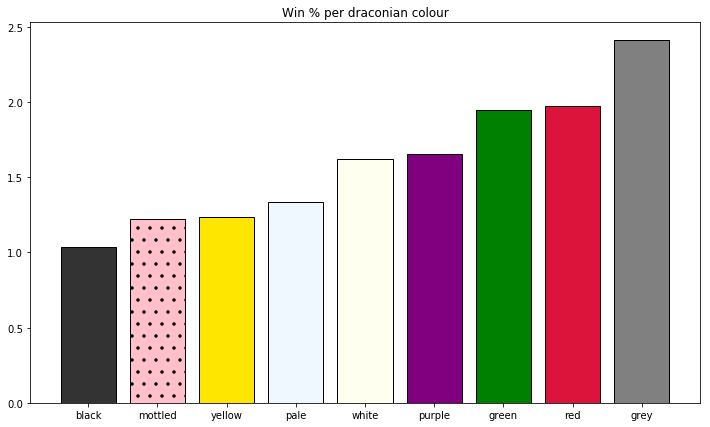

In [2]:
fig, ax = plt.subplots(figsize=(12,7))
colours = [(.2,.2,.2), 'pink', (1,.9,0), 'aliceblue', 'ivory', 'purple', 'green', 'crimson', 'grey']
color_winrates = (f[cdrac_index].groupby('species')['won'].mean().dropna() * 100).sort_values()
xrange = np.arange(len(colours))
labels = [name.split()[0] for name in color_winrates.index]
bars = ax.bar(xrange, color_winrates.values, 
               color=colours, tick_label=labels, 
              edgecolor='black', lw=1,
              )
bars[1].set_hatch('.')
ax.set_title('Win % per draconian colour');

To recap: Draconians are one of the starting species in DCSS. When draconian characters hit level 7, they're randomly assigned one of 9 colours, each of which comes with a unique 'breath' ability and set of passive traits. There's some debate as to which colours are the strongest and weakest. 

This data certainly seems to suggest that grey draconians are the best and black are the worst. By a lot, even - a random grey draconian game from our dataset is about 3 times as likely to end in victory as a black one. But I wanted to know: could these differences just be random noise from a small sample size?

To start, let's see just how many games we have for each colour.

In [17]:
games = f[cdrac_index].groupby('species').size()[colored_dracs].rename('games played')
wins = f.loc[cdrac_index & iwon].groupby('species').size()[colored_dracs].rename('games won')
pct = (100 * wins/games).rename('win %')
drac_table = pd.concat([games, wins, pct], axis=1).sort_values('win %', ascending=0)
dt2 = drac_table.copy()
dt2.index = dt2.index.astype('object')
dt2 = dt2.append(drac_table.sum().rename('Overall'))
ov = dt2.loc['Overall']
ov['win %'] = ov['games won'] * 100 / ov['games played']
cdrac_wr = ov['win %'] / 100
print dt2
# TODO: number formatting

                   games played  games won     win %
species                                             
grey draconian           2200.0       53.0  2.409091
red draconian            2282.0       45.0  1.971954
green draconian          2206.0       43.0  1.949229
purple draconian         2174.0       36.0  1.655934
white draconian          2222.0       36.0  1.620162
pale draconian           2174.0       29.0  1.333947
yellow draconian         2272.0       28.0  1.232394
mottled draconian        2206.0       27.0  1.223935
black draconian          2311.0       24.0  1.038511
Overall                 20047.0      321.0  1.601237


That's a lot of games, but the number of victories per colour is just a few dozen. So **are these differences statistically significant?** Let's math!

Our null hypothesis here is that the probability of winning the game is equal for all draconian colours. 

### Using the binomial test

The [binomial test](https://en.wikipedia.org/wiki/Binomial_test) is a nice simple place to start. It's a test that can answer questions like "how unlikely is it that a fair coin would land heads at least 15 times out of 20 tosses?", and answer them exactly. We can calculate the probability of exactly k heads as...

$$P(H=k) = \binom{20}{k} .5^{20}$$
    
So the answer to our question is just...

$$\sum_{k=15}^{20} P(H=k)$$

In general, the binomial test can answer any question of the form "how likely is it to get an outcome as extreme as k successes in n trials given a probability of success p?". 

So let's imagine the true probability of winning for any colour of draconian is just the average win rate over all colours in our sample (1.6%). Assuming this is the case, what's the chance that, when sampling ~2200 games, we get a win rate as few as 24 wins, or as many as 53? 

In [15]:
from scipy.stats import binom_test

def binom_pvalue(row):
    played, won = row[['games played', 'games won']]
    return binom_test(won, played, cdrac_wr, alternative='two-sided')

drac_table.apply(lambda d: binom_pvalue(d), axis=1).rename('p-value')

species
grey draconian       0.004826
red draconian        0.155936
green draconian      0.202078
purple draconian     0.797601
white draconian      0.932517
pale draconian       0.391743
yellow draconian     0.180546
mottled draconian    0.174336
black draconian      0.030657
Name: p-value, dtype: float64

So under our null hypothesis, the chances of randomly observing a win rate as extreme as those of grey or black draconians are .5% and 3%, respectively. If we choose a typical significance level of 5%, then **these are good enough to call significant**. The other colours, however, don't meet that significance threshold.

But there's a problem here. The chance of any given group having a significant p-value given the null hypothesis is 5%, but I tested *nine* groups. The more hypotheses I test, the greater the chance that one will produce a false positive ([relevant xkcd](https://xkcd.com/882/)). 

A really simple mitigation is the [Bonferroni correction](https://en.wikipedia.org/wiki/Bonferroni_correction), which just cuts the significance threshold for each of n tests down to 1/nth of the desired overall significance level. With a new threshold of .05 / 9 ~= 0.006, only grey draconians' p-value makes the cut.

While we were lucky enough to get a significant result here, a major problem with this method is that it's too conservative with respect to our null hypothesis. It's possible to have a situation where none of our colours differs from the overall mean with p<.05, but where the probability of all the observations together given the null hypothesis is less than .05. Imagine, for example, 60 rolls of a die, with {1, 2, 3} coming up about 5 times each, and {4, 5, 6} coming up about 15 times each. Rolling 15 6's out of 60 rolls is not really enough evidence to conclude that the dice are rigged, but considering all 6 moderately weird counts together, we can be pretty confident the die isn't fair.

If we really wanted to nitpick, we might also complain that the hypothesis we're testing against is stronger than it needs to be. Our original null hypothesis was just that the win rates of all draconian colours are the same, *not* that the win rates of all draconian colours are equal to the overall draconian sample mean that we measured at 1.6%.

So rather than calculating grey draconians' p-value as

    prob(>=53 games won out of 2200 | winrate=.016)
    
What we'd really like is to take the integral of that function over all win rates `p` from 0 to 1, weighted by a suitable prior on `p` (a [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) having α = 321, β = 20047 is a good representation of where we would expect the overall win rate to fall, given the wins and losses in our sample).

It turns out this kind of compound distribution is common enough to have a name and a Wikipedia article: it's a [beta-binomial distribution](https://en.wikipedia.org/wiki/Beta-binomial_distribution). Neat.

But this still doesn't help us with the main problem of combining p-values per colour to get a single p-value for our null hypothesis. Let's move on to the conventional test for these kinds of situations, which does address this problem.

### The chi-squared test

[Pearson's chi-squared test](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test) takes as input a table of the frequencies of some outcomes (e.g. winning and losing) over some categories (e.g. draconian colours), and gives us a measure of the likelihood of these observations given a hypothetical distribution (e.g. our null hypothesis that all colours having the same win rate).

It's not as intuitive as the binomial test, and unlike the binomial test, it is *not exact*. It relies on the data being normally distributed, which is [asymptotically true](https://en.wikipedia.org/wiki/Binomial_distribution#Normal_approximation) for binomially/multinomially distributed data such as ours. (That Wikipedia section gives some rules of thumb for whether the normal approximation is appropriate, which our data conform to.) There is an equivalent exact test, [Fisher's exact test](https://en.wikipedia.org/wiki/Fisher%27s_exact_test), but it's computationally expensive.
    
On the other hand, a nice aspect of this test is that we don't need to worry about combining p-values from several tests, or raising our threshold to account for multiple comparisons. Whereas before we separately tested 9 hypotheses ("Do grey draconians win significantly more?", "Do purple draconians win significantly more?", ...), now we're applying one test to all the data to test one hypothesis: are there any significant differences in win rate among colours?

In [5]:
from scipy.stats import chi2_contingency

chi2, p, dof, _ = chi2_contingency(
    drac_table[ ['games played', 'games won']].values
)
print "chi^2 = {}\tp-value = {}\tdegrees of freedom={}".format(chi2, p, dof)

chi^2 = 21.682640495	p-value = 0.00553897436172	degrees of freedom=8


Significant! **There's likely a real difference in win rate among colours.**

But this doesn't tell us *which* groups differ significantly from the overall mean, or which pairs of colours differ significantly from one another. For the former, the p-values per colour that we calculated previously probably serve as a pretty good key to sort on. But the latter is tricky to do in a principled way.

### Comparing colours pair-wise

A [z-test](https://people.richland.edu/james/lecture/m113/two_proportions.html) is a simple way to test whether two samples of some event frequencies differ in proportion. Like the chi-square test, it takes advantage of the normal approximation of binomial data. Let's use it to compare grey dragons with their lesser siblings.

In [14]:
import math
from scipy.stats import norm
def z_test(x1, n1, x2, n2):
    p1 = x1/n1
    p2 = x2/n2
    pbar = (x1+x2)/(n1+n2)
    qbar = (1 - pbar)
    numerator = p1 - p2
    denom = math.sqrt(pbar * qbar * (1/n1 + 1/n2))
    return numerator/denom

n1, x1 = drac_table[['games played', 'games won']].loc['grey draconian']
std_norm = norm()


def ztest_pvalue(row):
    n2, x2 = row[['games played', 'games won']]
    z = z_test(x1, n1, x2, n2)
    return std_norm.cdf(-abs(z)) * 2 # times 2 for 2-tailed test. Which I assume is appropriate.

drac_table.apply(lambda d: ztest_pvalue(d), axis=1).rename('p-value')

species
grey draconian       1.000000
red draconian        0.317117
green draconian      0.295831
purple draconian     0.077734
white draconian      0.061783
pale draconian       0.008760
yellow draconian     0.003179
mottled draconian    0.003220
black draconian      0.000382
Name: p-value, dtype: float64

Let's start with the easy conclusions. If we wish to keep using a significance level of 5% (i.e. mistakenly reject the null hypothesis no more than 5% of the time), then we do not have sufficient evidence to conclude that grey draconians are significantly better than red, green, purple, or white draconians. Or grey draconians, I guess.

Can we conclude that pale, yellow, mottled and black draconians are all worse than grey? Unfortunately the problem of multiple comparisons rears its head again, and even dividing our p-value threshold by 9 isn't enough to save us this time, because I've committed a new crime: [Testing hypotheses suggested by the data](https://en.wikipedia.org/wiki/Testing_hypotheses_suggested_by_the_data).

The decision to fix grey as the colour to compare all others against wasn't arbitrary. I chose that colour because I saw it had the highest win rate. 

In some sense, my p-values should probably be adjusted according to the number of tests I'd need to do to find a given effect *without being guided by snooping the data*. So perhaps I need to go as far as dividing my threshold by the number of all possible pairs? 

Let's give it a shot, applying the slightly more powerful [Holm-Bonferroni method](https://en.wikipedia.org/wiki/Holm%E2%80%93Bonferroni_method).

In [13]:
def ztest_pair_pvalue(row):
    n1, x1, n2, x2 = row[['games played_x', 'games won_x', 'games played_y', 'games won_y']]
    z = z_test(x1, n1, x2, n2)
    return std_norm.cdf(-abs(z)) * 2

def holm_bonferonni(row, m):
    alpha = .05
    rank, p = row[['rank', 'p']]
    thresh = alpha / (m-rank)
    return thresh

drac1 = drac_table[['games played', 'games won']].copy()
drac1['tmp'] = 1
drac1['species'] = drac_table.index
drac2 = drac1.copy()
pairs = pd.merge(drac1, drac2, on='tmp')
# One row for each distinct pair with non-identical species
iuniq = pairs['species_x'] < pairs['species_y']
pairs = pairs.loc[iuniq]
paired_p = pairs.apply(lambda d: ztest_pair_pvalue(d), axis=1).rename('p')
paired_p.sort_values(inplace=True)
paired_p = paired_p.to_frame()
paired_p['rank'] = range(len(paired_p))
paired_p['thresh'] = paired_p.apply(lambda d: holm_bonferonni(d, len(paired_p)), axis=1)
pairs.loc[paired_p.index][['species_x', 'species_y']]
under = paired_p['p'] <= paired_p['thresh']
print "Significant pairs...\n"
print pairs.loc[under[under].index][['species_x', 'species_y']]

Significant pairs...

          species_x       species_y
72  black draconian  grey draconian


As it turns out, **(black, grey) is the only pair whose difference we can be confident about**.

(Holm-)Bonferroni has the nice properties of being simple and working everywhere, but it can be overly conservative. There seem to be some more powerful methods tailored to this specific problem, which use the [Studentized range distribution](https://en.wikipedia.org/wiki/Studentized_range_distribution), but they're tricky.

## Dredging vs. spear-fishing

The reason we're needing to apply such harsh penalties to our p-values is that we're [data dredging](https://en.wikipedia.org/wiki/Data_dredging). We're exhaustively checking all possible relationships, and the more comparisons we do, the more stringent we need to be about the p-value of any particular test.

Therefore, an attractive alternative is to test a smaller number of targeted hypotheses formed *before* looking at the data, based on some prior knowledge of the domain. I looked at a few forum posts about draconian colours...

- [Rank the draconian colors](https://crawl.develz.org/tavern/viewtopic.php?f=5&t=10176&p=140405)
- [Tier list: Draconian colors](https://crawl.develz.org/tavern/viewtopic.php?f=17&t=19271&p=261183)
- [Buff certain draconian colors](https://crawl.develz.org/tavern/viewtopic.php?f=8&t=20683&p=279050)

and took five posts that assessed all nine colours, and roughly translated them into grades of low/medium/high. There was a lot of disagreement, but Yellow was clearly the worst ranked (5/5 low ratings), and Red the best (4 high ratings, 1 medium). This suggests a single hypothesis to test: **are red draconians better than yellow?**

In [8]:
print paired_p['p'].loc[(pairs['species_x']=='red draconian') & (pairs['species_y']=='yellow draconian')].values[0]

0.0469299129725


**Yes.** The wisdom of the masses prevails! (With p < .05)

And actually, we can cut that measured p-value in half, because we're doing a one-tailed test. That is, we're testing the hypothesis that red's win rate is significantly *better than* yellow's, not just significantly different from it.

## Error bars

Finally, let's see if we can stick some error bars on our chart. I'll be using 95% confidence intervals, though another valid approach would be to use the [standard error of the mean](https://en.wikipedia.org/wiki/Standard_error).

Wikipedia describes at least [seven](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval) methods for calculating confidence intervals for binomial proportions. None of them have scipy oneliners, so I mopped a code snippet from on [StackOverflow](http://stackoverflow.com/a/24023800/262271). (It implements the [Wilson score interval](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Wilson_score_interval)).

Let's use it to calculate 95% confidence intervals for each win rate, and plot them as error bars.

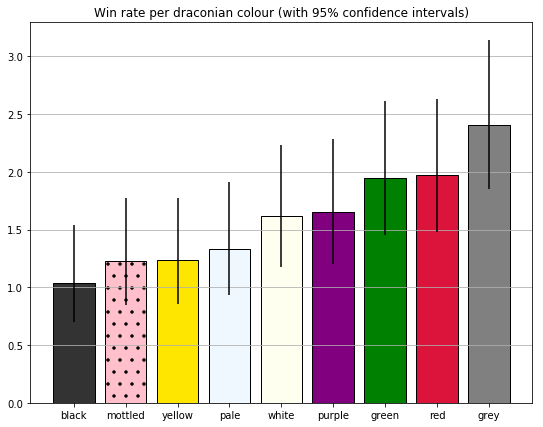

In [9]:
from bin_conf import binconf

err_low = drac_table.apply(
    lambda row: binconf(row['games won'], (row['games played']-row['games won']), c=.95)[0],
    axis=1) * 100
err_high = drac_table.apply(
    lambda row: binconf(row['games won'], (row['games played']-row['games won']), c=.95)[1],
    axis=1) * 100
cwr = color_winrates
# matplotlib wants offsets, not positions
err_low = color_winrates - err_low[cwr.index]
err_high = err_high[cwr.index] - color_winrates

fig, ax = plt.subplots(figsize=(9,7))
colours = [(.2,.2,.2), 'pink', (1,.9,0), 'aliceblue', 'ivory', 'purple', 'green', 'crimson', 'grey']
cdrac_index = f['species'].isin(colored_dracs)
color_winrates = (f[cdrac_index].groupby('species')['won'].mean().dropna() * 100).sort_values()
xrange = np.arange(len(colours))
labels = [name.split()[0] for name in color_winrates.index]
bars = ax.bar(xrange, color_winrates.values, 
               color=colours, tick_label=labels, 
              edgecolor='black', lw=1,
              yerr=[err_low[color_winrates.index].values, err_high[color_winrates.index].values],
              )
bars[1].set_hatch('.')
ax.set_title('Win rate per draconian colour (with 95% confidence intervals)');
ax.grid(axis='y');

These (pretty huge) error bars span a range that we can be 95% confident contains the true win rate for a given colour. 

These are useful for guiding our intuition about how much uncertainty we have about each measurement, though we can't really use them to make any rigorous claims about which pairs are significantly different.

It's tempting to assume that two colours differ with p < .05 if-and-only-if their confidence intervals fail to overlap, but that doesn't hold up. The probability that black's win rate is outside the C.I. is 5%, same for grey. If grey and black are to have the same win rate, then *both* those unlikely things need to happen (or one of their win rates needs to be *way* outside the confidence interval). C.I.'s failing to overlap is at least a sufficient condition to conclude that two means are likely different, but that's not taking into account multiple comparisons.

## Conclusions

From these experiments, a really anal-retentive statistician would probably be willing to accept the following conclusions:

- Grey draconians are better than black draconians.
- Red draconians are better than yellow draconians.

(We also separately showed that draconian colour is not independent of win rate, though this is implied by either of the two claims above.)

We could reasonably intuit some more claims about the data ("grey draconians are better than mottled", "pale draconians aren't the best colour"), but it's surprisingly difficult to make sound statistical arguments for some seemingly obvious patterns.

It's interesting to compare the statistics with the opinions players gave on the forums. Yellow, the only colour that got consistently bad ratings, did turn out to have a low win rate, and Red, the colour with the most consistently positive ratings, did have a high win rate. On the other hand:

- None of the five posters I reviewed put grey draconians in their top bracket. They were consistently rated in the middle or just above the middle.
- No-one put black draconians in their bottom bracket. Three posters rated them below average, and two rated them above average.